In [116]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout,Activation, Lambda,LeakyReLU,ReLU
from tensorflow.keras.layers import Conv2D,MaxPooling2D,BatchNormalization,LayerNormalization,GlobalMaxPooling2D
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import pandas as pd
import numpy as np
import os

from image_utils import get_pairs,get_dataset_info,estimate_dataset


# Human classification

I use opensourse SoF dataset( https://www.sites.google.com/view/sof-dataset ). let's look at the resized images 

In [114]:
folders=os.listdir(main_folder_name)
image_weight_folder=folders[0]
folder_image_name=os.listdir(main_folder_name+'/'+image_weight_folder)[0]
image=imread(main_folder_name+'/'+ image_weight_folder+'/'+folder_image_name)
plt.imshow(image)

## Define images main information

In [78]:
main_folder_name='dataset'
get_dataset_info(main_folder_name)

-------------------------------------------------------
Dataset info

image shape =  (128, 128, 3)
image weight =  48.0  KiB
number of classes =  4
number of pictures =  164
positive pairs count = 8506
positive pairs images weight = 0.779  GiB
negative pairs count = 18390
negative pairs images weight = 1.684  GiB

total memory size = 2.463  GiB


## Define dataset parametrs 

In [79]:
image_shape=(128,128,3)
main_folder_name='dataset'
max_positive_pairs_count=9000
max_negative_pairs_count=19000
estimate_dataset(main_folder_name,
                 max_positive_pairs_count,
                 max_negative_pairs_count)

-------------------------------------------------------
Estimated info

desired positive pairs count = 9000
positive pairs images weight = 0.824  GiB

desired negative pairs count = 19000
negative pairs images weight = 1.74  GiB

total memory size = 2.564  GiB


## Preprocces the images

In [40]:
pairs,labels=get_pairs(main_folder_name,
                       max_positive_pairs_count,
                       max_negative_pairs_count)

Calculation began

Calculation is done

passed seconds:  16.078  seconds


In [41]:
train_pairs,test_pairs,train_labels,test_labels=train_test_split(pairs,labels,test_size=0.05)

## Siamese pecularity

As siamese network measure distance between we define Euclidean distance Lambda layer and special contrastive loss ( https://arxiv.org/abs/2011.02803 )

In [80]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
    
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean( (1 - y_true) * square_pred+y_true*margin_square)
    
    return contrastive_loss

In [81]:
def get_model():
    #
    #   it is also good idea to use VGG model, but it requires powerfull GPU
    #   model = Sequential(VGG16(weights='imagenet', include_top=False, input_shape=image_shape).layers)
    #
    model=Sequential()
    
    model.add(Conv2D(32,(3,3),input_shape=image_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3)))
    model.add(MaxPooling2D((2,2)))
        
    model.add(Conv2D(64,(3,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3)))
    model.add(MaxPooling2D((2,2)))

    model.add(Conv2D(128,(3,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3)))
    model.add(MaxPooling2D((3,3)))
    
    model.add(Conv2D(256,(3,3)))
    model.add(BatchNormalization())
    model.add(Conv2D(256,(3,3)))
    model.add(MaxPooling2D((3,3)))
    
    model.add(Flatten())
    model.add(Dense(512))
    model.add(LeakyReLU(0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(0.2))

    return model

In [82]:
base_network = get_model()
base_network.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_20 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 124, 124, 32)      9248      
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
batch_normalization_21 (Batc (None, 60, 60, 64)        256       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 58, 58, 64)       

## Define siamese model

To provide weights sycronization we define left and right inputs with the same model

In [84]:
input_a = Input(shape=image_shape)
vect_output_a = base_network(input_a)

input_b = Input(shape=image_shape)
vect_output_b = base_network(input_b)

x = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([vect_output_a, vect_output_b])
output= Dense(1,activation='sigmoid')(x)

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

In [85]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
sequential_7 (Sequential)       (None, 256)          1437088     input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 1)            0           sequential_7[1][0]         

## Model training

*Important*, 43 epochs take 4 hours to train on gxt 980 ti. Make sure, that you have enough computation power

In [107]:
optim = RMSprop(  learning_rate=0.00001)
#optim = Adam(  learning_rate=0.015)
model.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=optim)
history = model.fit([train_pairs[:,0],train_pairs[:,1]], 
                    train_labels, 
                    epochs=43, 
                    batch_size=18,
                    validation_split=0.2)

## Save weights and history

In [143]:
model.save_weights('saved data/weight.h5')
hist_df = pd.DataFrame(history.history) 
hist_json_file = 'saved data/history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

## Load weights and history

In [86]:
model.load_weights('saved data/weight.h5')
load_history=pd.read_json('saved data/history.json')

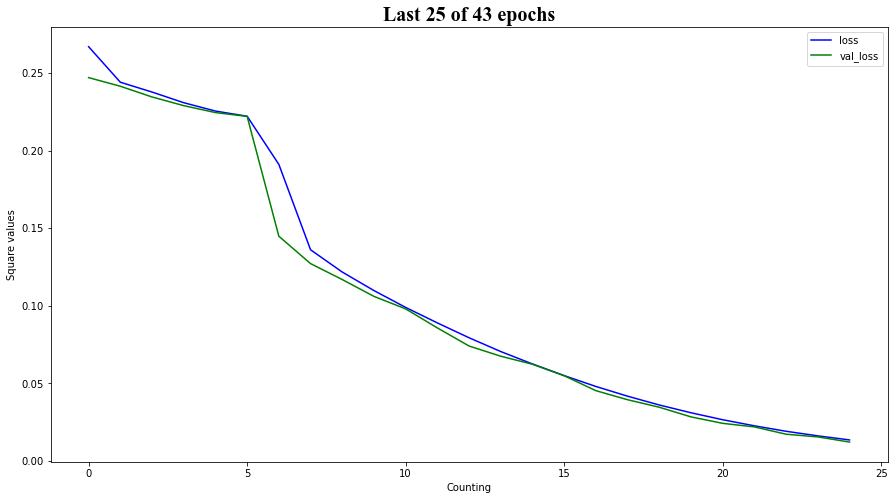

In [106]:
loss=new_pd_history['loss']
val_loss=new_pd_history['val_loss']
x=range(len(loss))
X=15
Y=8
plt.figure(figsize=(X,Y))
plt.plot(x,loss,'b',x,val_loss,'g')
plt.title('Last 25 of 43 epochs', fontsize=20, fontname='Times New Roman')
plt.legend(['loss','val_loss'])
plt.xlabel('Counting')
plt.ylabel('Square values')
plt.show()

## Model testing

In [108]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() > 0.5
    return round(np.mean(pred == y_true),4)

In [109]:
loss = model.evaluate(x=[new_pairs[:,0],new_pairs[:,1]], y=new_labels)

y_pred_train = model.predict([new_pairs[:,0], new_pairs[:,1]])
train_accuracy = compute_accuracy(new_labels, y_pred_train)

y_pred_test = model.predict([test_pairs[:,0], test_pairs[:,1]])
test_accuracy = compute_accuracy(test_labels, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

26600/26600 [==============================] - 101s 4ms/sample - loss: 0.0075
Loss = 0.007514905655770597, Train Accuracy = 0.5664 Test Accuracy = 0.5561
